**This notebook introduces how to apply gaussian process to predict the global temperature. <br/>**


Reference: https://github.com/duncanwp/ClimateBench/blob/main/baseline_models/ClimateBenchGP_tas.ipynb

**Note:** You would need the `gpflow` package to run this notebook. `gpflow` is built upon tensorflow and is widely used to build Gaussian process models in python.

Before we install gpflow, we need to upgrade the tensorflow version in the JupyterHub. Please execute `pip install --upgrade tensorflow` and `pip install gpflow` in the first and second code section.

Restart the kernal after installing new packages

In [2]:
pip install --upgrade tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Obtaining dependency information for libclang>=13.0.0 from https://files.pythonhosted.org/packages/ea/df/55525e489c43f9dbb6c8ea27d8a567b3dcd18a22f3c45483055f5ca6611d/libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl.metadata
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached wrapt-1.14.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (77 kB)
  Obtaining dependency information for tensorflow-io-gcs-filesystem>=0.23.1 from https://files.pythonhosted.org/packages/88/99/8b507a009359fd55e411001acb64a1a8a4f81a26cb6e21c3b75c7fda4ae3/te

In [3]:
pip install gpflow

Note: you may need to restart the kernel to use updated packages.


#### Please restart the kernal after installing new packages. 
#### Skip the pip-related code above and run the following code sections.

In [1]:
import tensorflow as tf
print(tf.__version__)
# before upgrade it was 2.12

2023-10-25 18:41:56.019097: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 18:41:56.022380: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 18:41:56.084847: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 18:41:56.084864: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 18:41:56.084882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

2.14.0


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
from glob import glob

import tensorflow as tf
import gpflow
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [3]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [4]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [5]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

#### Data standardization

In [6]:
# Standardize the predictors
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test  = X_test_df.to_numpy()


In [7]:
# Standardize the predictand 
y_train    = y_train_df.to_numpy().astype(np.float64)
train_tas_mean, train_tas_std = y_train.mean(), y_train.std()
y_train    = (y_train - train_tas_mean) / train_tas_std


print(X_train.shape,y_train.shape,X_test.shape)

(753, 2) (753, 13824) (86, 2)


### 2. Build & train the Gaussian process model

In [ ]:
gpflow.kernels.Exponential?

In [8]:
# Define the kernels Matern32, full list here https://gpflow.github.io/GPflow/develop/api/gpflow/kernels/index.html
#gpflow.kernels.Matern32
#class gpflow.kernels.Matern32(variance=1.0, lengthscales=1.0, **kwargs)[source]
#Bases: IsotropicStationary
#The Matern 3/2 kernel. Functions drawn from a GP with this kernel are once differentiable. The kernel equation is
#k(r) = σ² (1 + √3r) exp{-√3 r}

#kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
#kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

# The Exponential kernel. It is equivalent to a Matern12 kernel with doubled lengthscales
kernel_CO2 = gpflow.kernels.Exponential(active_dims=[0])
kernel_CH4 = gpflow.kernels.Exponential(active_dims=[1])


kernel = kernel_CO2 + kernel_CH4

# Define the model
np.random.seed(5)
mean  = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train, y_train),
                          kernel=kernel,
                          mean_function=mean)

# Define optimizer
opt = gpflow.optimizers.Scipy()

In [9]:
# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07448D+07    |proj g|=  2.74909D+06


 This problem is unconstrained.



At iterate    1    f=  4.82111D+06    |proj g|=  1.19088D+06

At iterate    2    f=  4.58163D+06    |proj g|=  1.35362D+05

At iterate    3    f=  4.57193D+06    |proj g|=  8.03819D+04

At iterate    4    f=  4.56191D+06    |proj g|=  1.42096D+05

At iterate    5    f=  4.50953D+06    |proj g|=  3.66637D+05

At iterate    6    f=  4.45861D+06    |proj g|=  3.31644D+05

At iterate    7    f=  4.42217D+06    |proj g|=  1.18830D+04

At iterate    8    f=  4.42025D+06    |proj g|=  4.87541D+04

At iterate    9    f=  4.41933D+06    |proj g|=  5.33558D+04

At iterate   10    f=  4.41535D+06    |proj g|=  2.58167D+04

At iterate   11    f=  4.41200D+06    |proj g|=  1.69182D+04

At iterate   12    f=  4.41042D+06    |proj g|=  3.38402D+04

At iterate   13    f=  4.40903D+06    |proj g|=  2.58127D+04

At iterate   14    f=  4.40720D+06    |proj g|=  2.34781D+04

At iterate   15    f=  4.40693D+06    |proj g|=  2.38302D+04

At iterate   16    f=  4.40568D+06    |proj g|=  2.00221D+04

At iter

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4399049.671713565
        x: [ 9.948e+00  3.242e+00  2.242e+00 -1.334e+00 -2.061e+00
             9.569e-01]
      nit: 45
      jac: [ 3.713e-01 -5.674e-01  2.936e+00 -7.062e+00  1.028e+01
             1.471e+00]
     nfev: 55
     njev: 55
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

### 3. Evaluate the model

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test)
posterior_mean   = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std    = np.sqrt(standard_posterior_var) * train_tas_std

In [11]:
y_test_pre_mean = np.reshape(posterior_mean,[posterior_mean.shape[0], 96, 144])
y_test_pre_std  = np.reshape(posterior_std,[posterior_std.shape[0], 96, 144])

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                                 'latitude': X_test_xr.latitude.values, 
                                 'longitude': X_test_xr.longitude.values},
                             data_vars=dict(tas_mean=(['time', 'latitude', 'longitude'], y_test_pre_mean),
                                            tas_std=(['time', 'latitude', 'longitude'], y_test_pre_std)))

In [12]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.tas[35], y_test_pre.tas_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.tas[85], y_test_pre.tas_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.tas[30:41], y_test_pre.tas_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.tas[75:], y_test_pre.tas_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.tas[35:], y_test_pre.tas_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre.tas_mean[-20:].mean(dim='time'))}")

RMSE at 2050: 0.30834725889057774
RMSE at 2100: 0.35088100111994186
RMSE 2045-2055: 0.35347852799031987
RMSE 2090-2100: 0.3721762738764541
RMSE 2050-2100: 0.38843422976281533
RMSE average last 20y: 0.1849572280777414


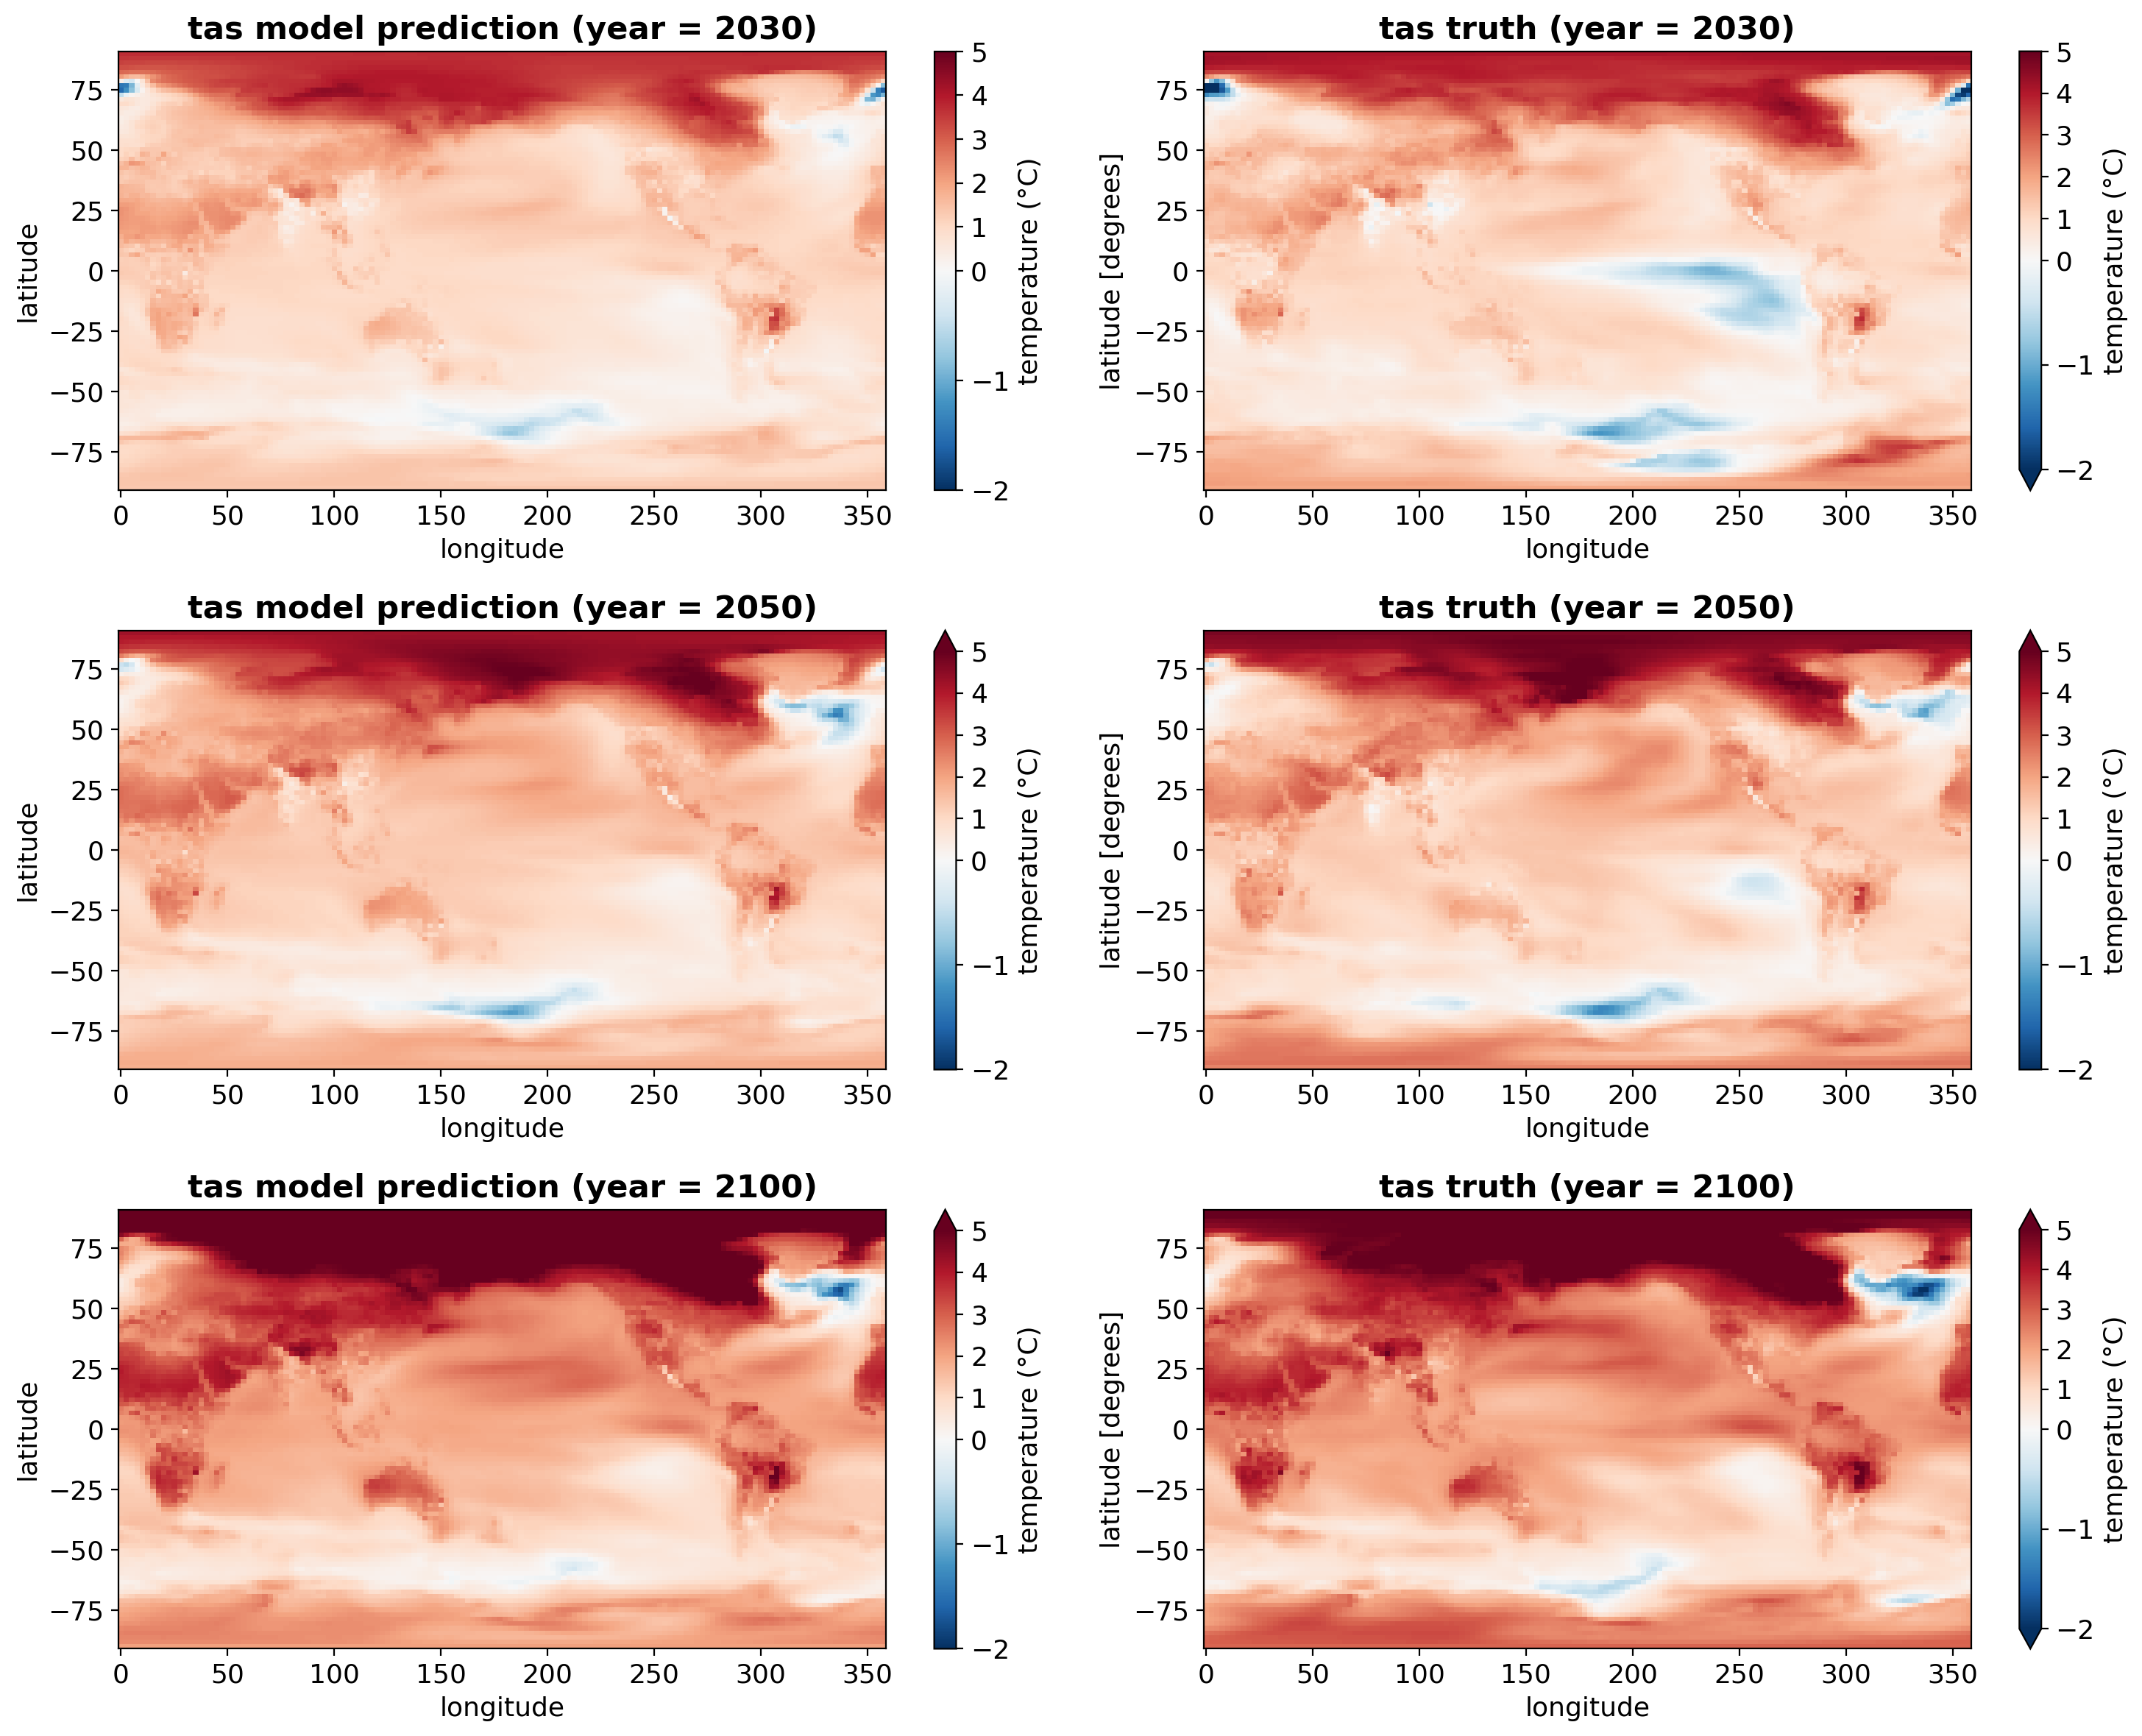

In [13]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 5
cmap = 'RdBu_r'
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

y_test_pre.tas_mean.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

In [14]:

# The Exponential kernel. It is equivalent to a Matern12 kernel with doubled lengthscales
kernel_CO2 = gpflow.kernels.Exponential(active_dims=[0])
kernel_CH4 = gpflow.kernels.Exponential(active_dims=[1])


kernel = kernel_CO2 + kernel_CH4

# Define the model
np.random.seed(5)
mean  = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train, y_train),
                          kernel=kernel,
                          mean_function=mean)

# Define optimizer
opt = gpflow.optimizers.Scipy()

In [15]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test)
posterior_mean   = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std    = np.sqrt(standard_posterior_var) * train_tas_std

In [16]:
y_test_pre_mean = np.reshape(posterior_mean,[posterior_mean.shape[0], 96, 144])
y_test_pre_std  = np.reshape(posterior_std,[posterior_std.shape[0], 96, 144])

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                                 'latitude': X_test_xr.latitude.values, 
                                 'longitude': X_test_xr.longitude.values},
                             data_vars=dict(tas_mean=(['time', 'latitude', 'longitude'], y_test_pre_mean),
                                            tas_std=(['time', 'latitude', 'longitude'], y_test_pre_std)))

In [17]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.tas[35], y_test_pre.tas_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.tas[85], y_test_pre.tas_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.tas[30:41], y_test_pre.tas_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.tas[75:], y_test_pre.tas_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.tas[35:], y_test_pre.tas_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre.tas_mean[-20:].mean(dim='time'))}")

RMSE at 2050: 0.3019499364739041
RMSE at 2100: 0.34407291509093285
RMSE 2045-2055: 0.3464675170855779
RMSE 2090-2100: 0.3673294923389138
RMSE 2050-2100: 0.37470544182476473
RMSE average last 20y: 0.18681008424717072


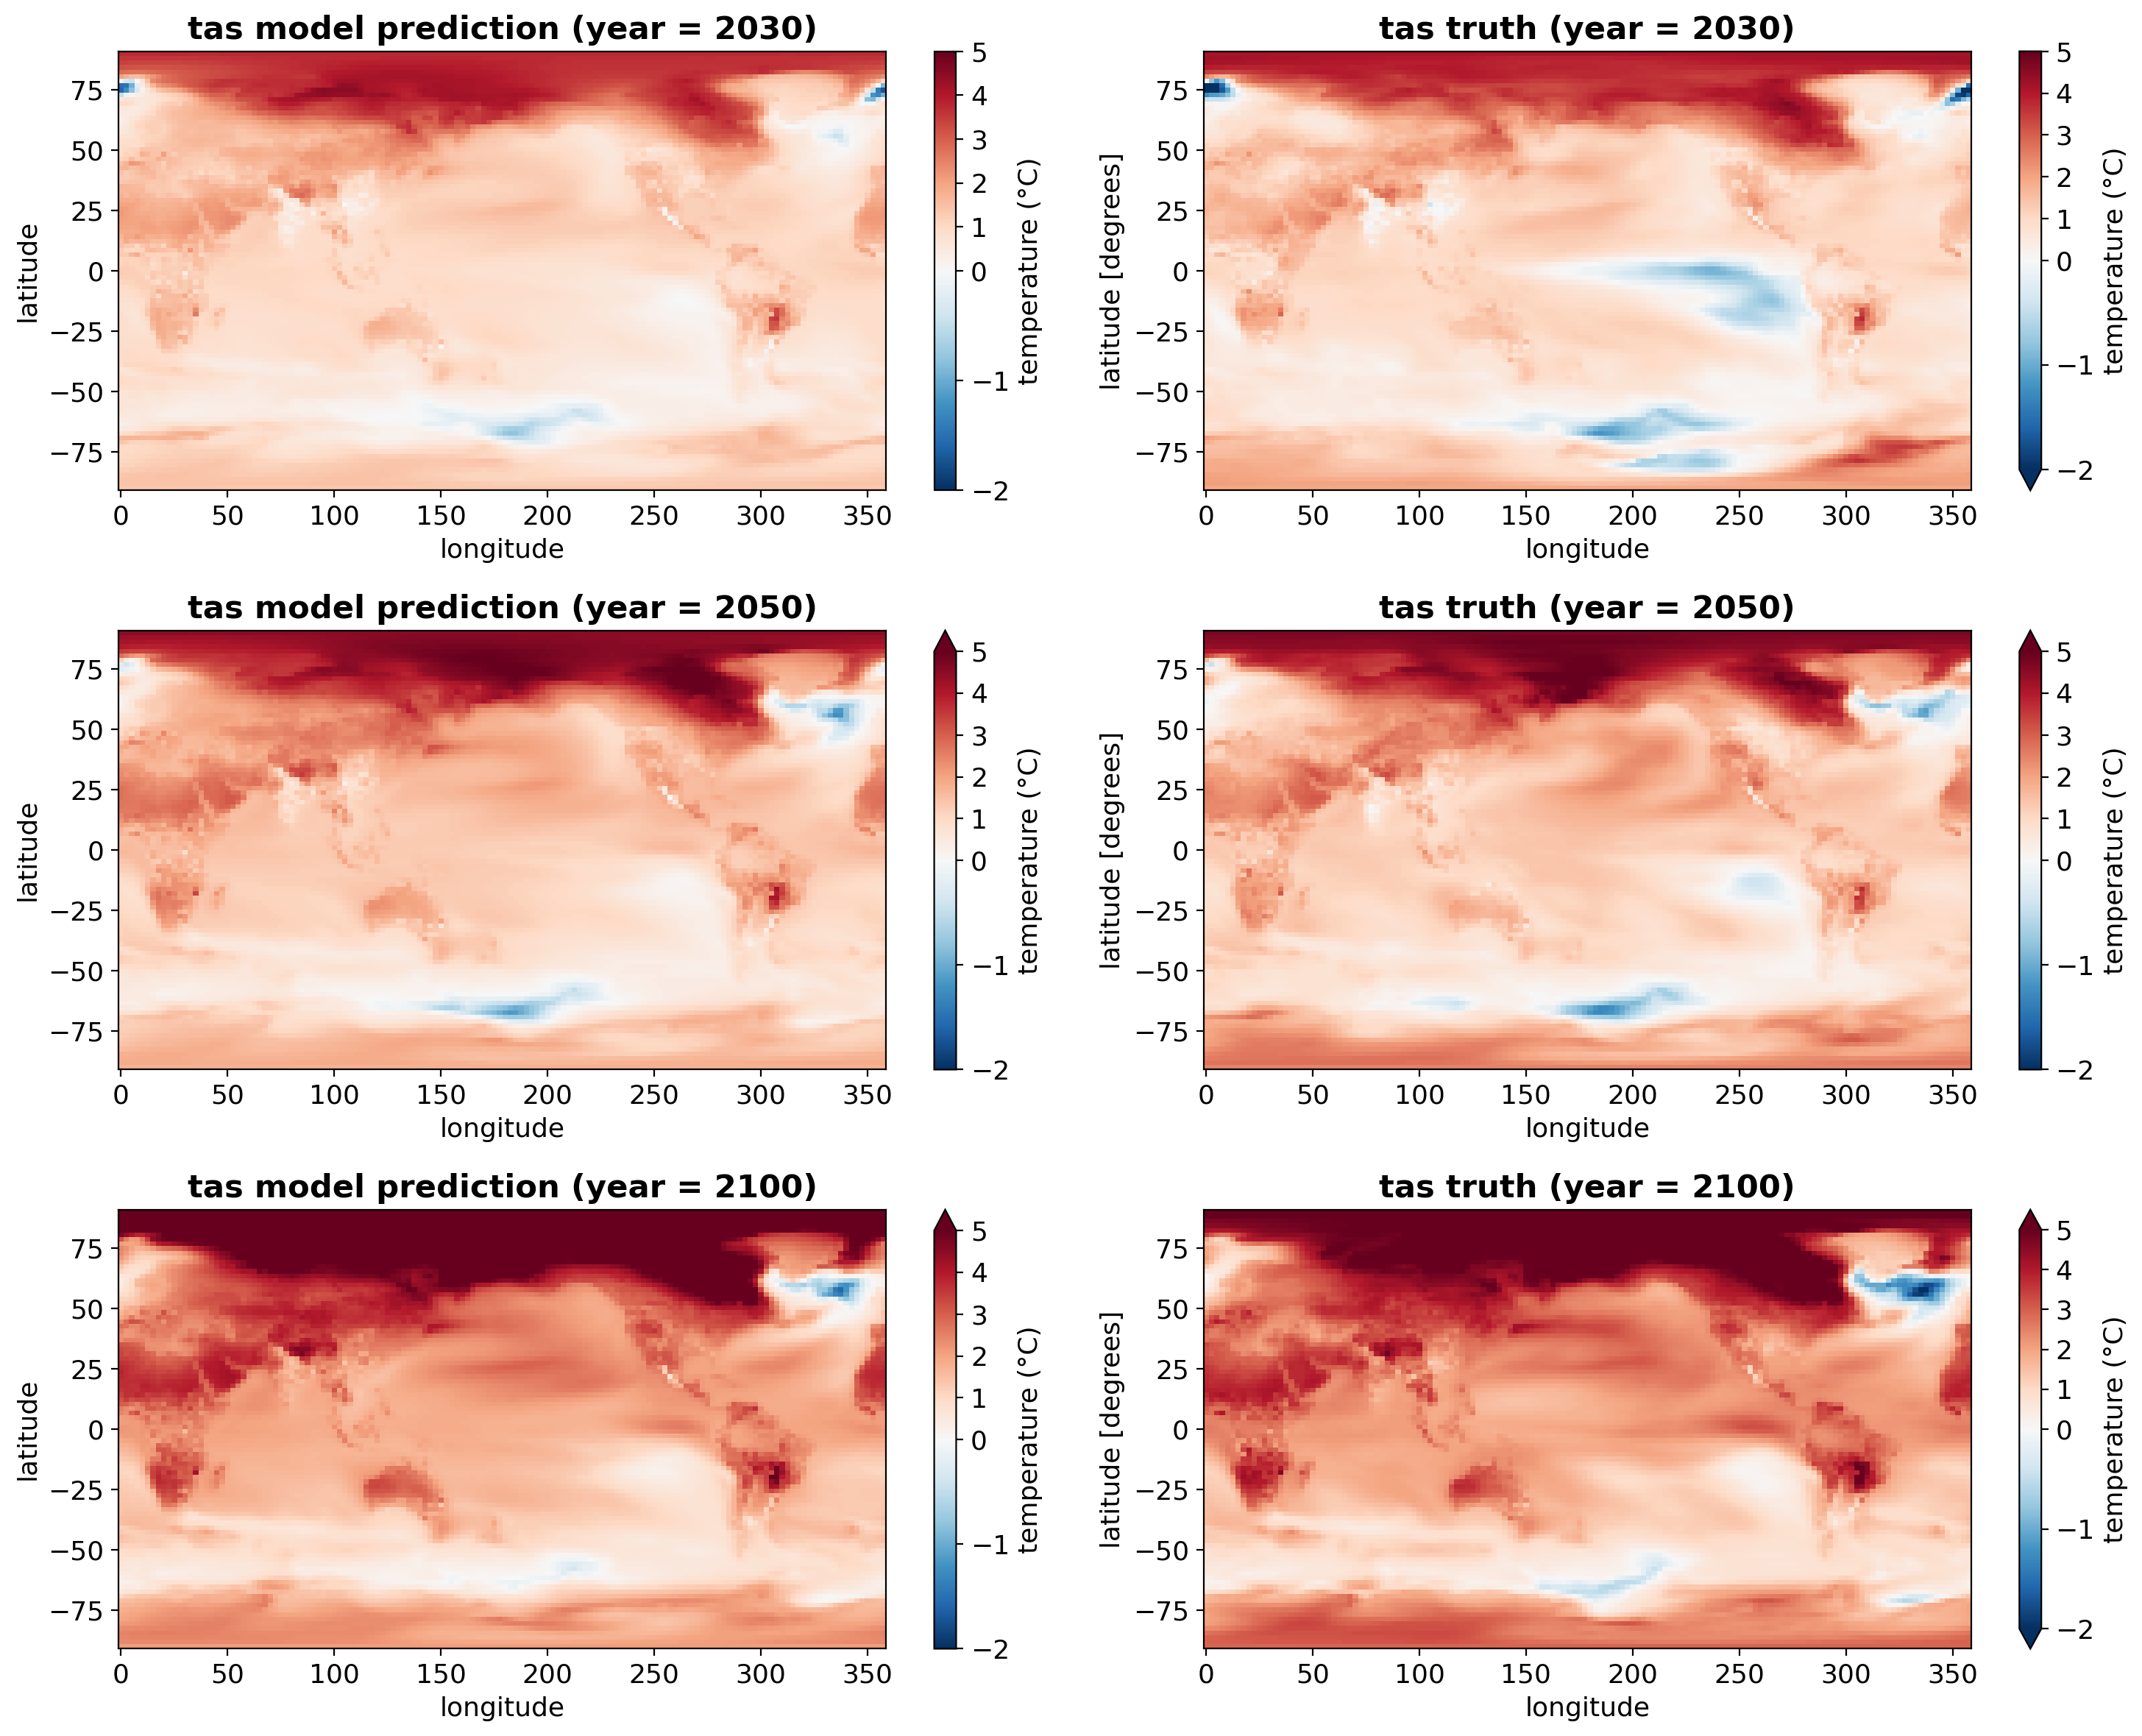

In [18]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 5
cmap = 'RdBu_r'
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

y_test_pre.tas_mean.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'temperature (°C)')

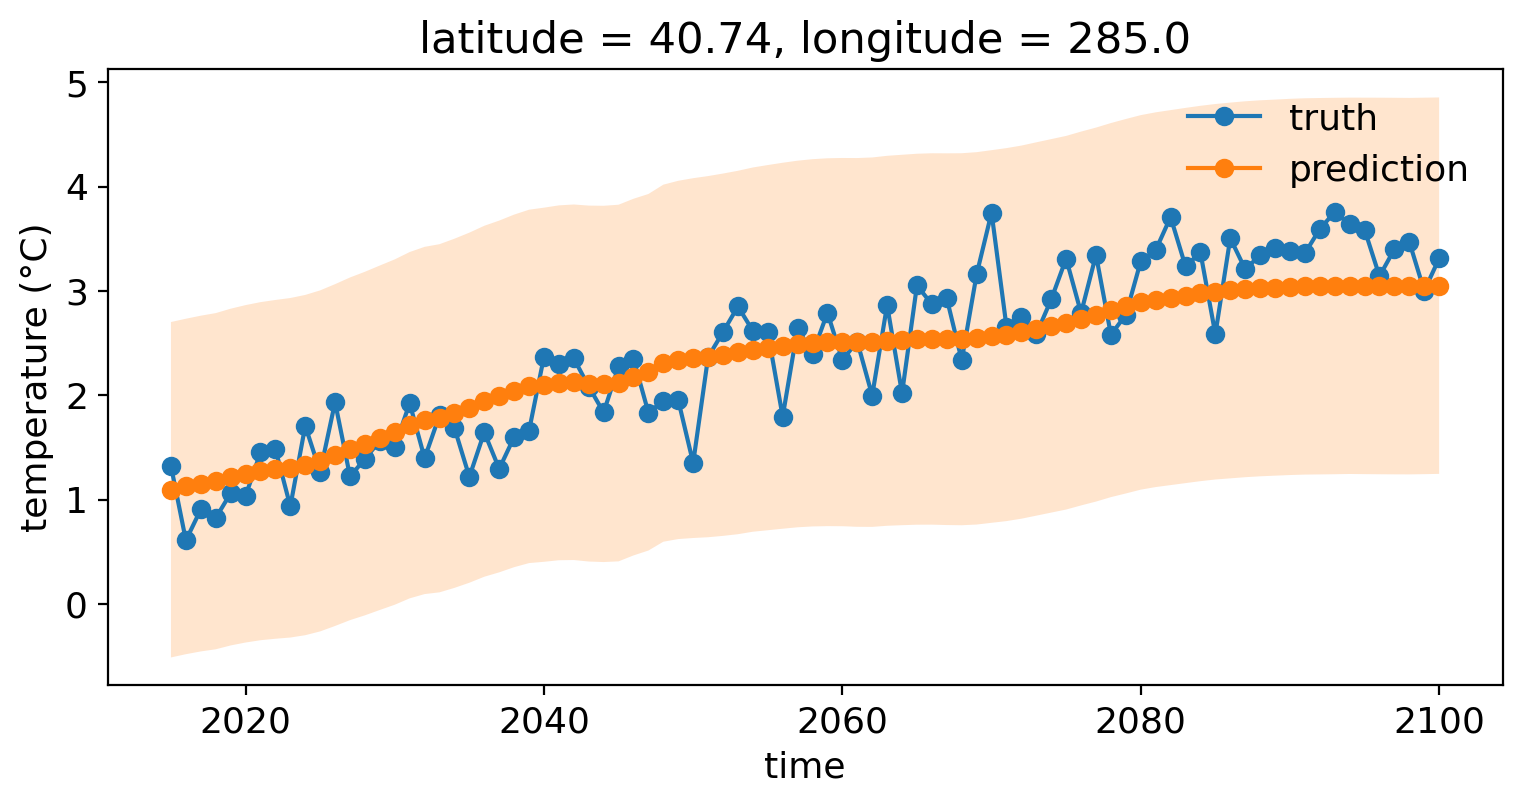

In [26]:
lat = 40.7128
lon = -74.0060%360

# extract the mean and std of air temperature prediction at NYC
y_test_pre_mean = y_test_pre["tas_mean"].sel(latitude=lat,longitude=lon,method='nearest').data
y_test_pre_std = y_test_pre["tas_std"].sel(latitude=lat,longitude=lon,method='nearest').data
y_test_pre_time = y_test_pre.time.data

# plot
fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:blue',label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas_mean.plot(marker='o',ax=ax,color='tab:orange',label='prediction')
ax.fill_between(y_test_pre_time,y_test_pre_mean+y_test_pre_std,y_test_pre_mean-y_test_pre_std,facecolor='tab:orange',alpha=0.2)

ax.legend()
ax.set_ylabel('temperature (°C)')